# Faster script

##### Set up screen wide view

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\Luiz Eduardo\AppData\Local\Temp\ipykernel_26892\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Importations

## Import libraries and modules

In [2]:
##Import libraries
import os
import math
import pandas as pd
import itertools
import numpy as np
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.integrate import odeint
from celluloid import Camera
from cycler import cycler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
## Import functions

from Functions.objectGenerationRiver_func import*
from helpers.GlobalConstants import * 
from Functions.readImputParam import readProcessparam, microplasticData,readCompartmentData
from Functions.dilutionVol_calculator_func import*
from Functions.RC_estimation_function_v2_0 import*
from Functions.reshape_RC_df_fun import*
from Functions.fillInteractions_df_fun_v2_0 import*

## Import input files

In [4]:
### Import imput files
from pathlib import Path
data_folder = Path("Inputs/") 

process_df= readProcessparam (data_folder / "process_paramRiver.txt")
MP_prop = microplasticData(data_folder /"microplasticsSizeClassTests.txt")
compartments_prop = readCompartmentData(data_folder /"compartmentsGenericRiverSec_prop.txt")
river_flows=pd.read_csv(data_folder /"flow_connectivity.csv")
#Add river section depth field
RSdepth = []
for row in range(len(compartments_prop)):
        RSdepth.append(round(sum(compartments_prop.depth_m[0:4]),2))
compartments_prop["depthRS_m"]=RSdepth

# Model set up

In [5]:
#RIVER COMPARTMENTS
compartments = ["Surface Water", "Flowing Water", "Stagnant Water", "Sediment"]
riverComp = ["1", "2", "3", "4"]

In [6]:
#MICROPLASTICS FORMS 
MPforms = ["A", "B", "C", "D"]
MPformslabels = ["Free", "Heteroaggregated", "Biofiolm-covered", "Biofilm-heteroaggregated"]

In [7]:
#SIZE BINS
sizeBin =["a", "b", "c", "d", "e"]
sizeBinLabel = ["0.1um", "1um","10um", "100um", "1000um"]# Detection limit for MPs via Fourier Transform Infrared Spectroscopy is 20um

In [8]:
#MPS RIVER PROCESSES (FATE AND TRANSPORT) LIST
processList = ["degradation", "fragmentation", "heteroagg", "breakup", "settling","rising", "advection", "mixing", "biofilm", "resusp", "burial","sedTransport", "defouling"]

In [9]:
#RIVER SECTIONS
numberRS=len (compartments_prop)/len(riverComp)
listRS = [*range(0,int(numberRS),1)]
riverSect = [str(item) for item in listRS]
riverLengths = [str(it) for it in compartments_prop["length_m"]]
riverSectLength= riverLengths[0::4]
RS_cumLength_m =[]
for d in range(len(riverSectLength)):
    if d==0:
        RS_cumLength_m.append(float(riverSectLength[d]))
    else:
        RS_cumLength_m.append(float(riverSectLength[d])+float(RS_cumLength_m[d-1]))

## Define run parameters
- Solver (Dynamic). SteadyState under developement
- mode (Standard). Monthly under developement
- mode2 (Timelimit or raw): "Timelimit" mode sets up a time limit of 30min on the processes that exceeds that speed, while "raw" mode leaves the rate constant as calcualted. The raw version can straing the solver due to time.
- record (True or False) : if "True" the results, RC and intercations dataframes will be recorded in the Results folder.

In [10]:
SOLVER = "Dynamic" 
mode = "Standard" 
mode2 = "Timelimit" 
record = "False"

## Define scenario 
- composition: define MP composition to study. The composition is defined in the microplastics imput file microplasticsSizeClass.txt. Examples given in such file: PE, PA and PVC.
- imputMP: Define imput location and wich MP form is emmited by indicating the river section number, river compartment number, MP aggregation state and size bin: ex. 02Ae (RS=0:1, comp= 2:flowing water, MPtype:A:FreeMP, sizeBin:e:1000um)
- imputFlow: define number of particles per minute entering the system
- imputPulse: define number of particles entering the systems in a pulse (if any)

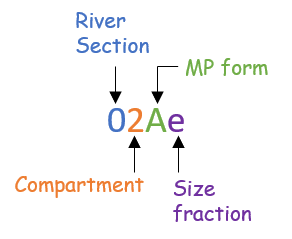

In [11]:
composition = "PA"
imputMP= "02Ae"
imputFlow=100 
imputPulse=0

## Set simulation time:
- t0: starting time (seconds)
- daysSimulation: total length of simulation (days)
- stepSize (seconds)

In [12]:
t0 = 0 
daysSimulation = 365
tmax = 24*60*daysSimulation*60 
sec_day = 24*60*60
stepSize= 60*60*24 #time step of 1day
timesteps = int(sec_day*daysSimulation/stepSize) 
t_span = np.linspace(0, tmax, int(timesteps)+1, dtype=int)

## Define model run results file name

In [13]:
#Set up current date label#
from datetime import datetime, timedelta
date_time_str = '2020-01-01 00:00'
DayStart = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M')
LastDay = DayStart + timedelta(seconds=tmax)
date = DayStart
daterun = date.today()
daterun_label = daterun.strftime("%Y_%m_%d")

In [14]:
if imputFlow !=0:
    runtitle= daterun_label+ "_GenericRiver_" + composition +"_inflow_"+ imputMP+"_"+str(imputFlow)+"part_s_"+ mode2+"_TestRun_v2_0"
else:
    runtitle= daterun_label+"_GenericRiver_" + composition +"_pulse_"+ imputMP+"_"+str(imputPulse)+"part_"+ mode2+"_TestRun_v2_0"
runtitle

'2024_03_14_GenericRiver_PA_inflow_02Ae_100part_s_Timelimit_TestRun_v2_0'

## Create results and figures folders (to be updated for working with Binder)

In [15]:
##Set current working directory
cwd=os.getcwd()

In [16]:
os.chdir(cwd+"/Comparações")
    
#create folder for the day if it doesnt already exists

path = cwd+"/Comparações"
os.path.isdir(path)
old_path = (daterun_label)
new_path = os.path.isdir(old_path)
if not new_path:
    os.makedirs(old_path)
    print("Created Folder : ", old_path)
else:
    print(old_path, "folder already exists.")

results_path= cwd+"/Comparações/"+old_path

os.chdir(results_path)

Fig_folder= "/HeatMaps"
os.path.isdir(results_path+Fig_folder)

new_path = os.path.isdir(results_path+Fig_folder)
if not new_path:
    os.mkdir("HeatMaps")
    print("Created Folder : ", Fig_folder)
else:
    print(Fig_folder, "folder already exists.")

results_figures_path= results_path+Fig_folder

2024_03_14 folder already exists.
/HeatMaps folder already exists.


In [17]:
os.chdir(cwd+"/Comparações")
    
#create folder for the day if it doesnt already exists

path = cwd+"/Comparações"
os.path.isdir(path)
old_path = (daterun_label)
new_path = os.path.isdir(old_path)
if not new_path:
    os.makedirs(old_path)
    print("Created Folder : ", old_path)
else:
    print(old_path, "folder already exists.")

results_path= cwd+"/Comparações/"+old_path

os.chdir(results_path)

Fig_folder= "/Concentration_over_time"
os.path.isdir(results_path+Fig_folder)

new_path = os.path.isdir(results_path+Fig_folder)
if not new_path:
    os.mkdir("Concentration_over_time")
    print("Created Folder : ", Fig_folder)
else:
    print(Fig_folder, "folder already exists.")

2024_03_14 folder already exists.
/Concentration_over_time folder already exists.


In [18]:
os.chdir(cwd+"/Comparações")
    
#create folder for the day if it doesnt already exists

path = cwd+"/Comparações"
os.path.isdir(path)
old_path = (daterun_label)
new_path = os.path.isdir(old_path)
if not new_path:
    os.makedirs(old_path)
    print("Created Folder : ", old_path)
else:
    print(old_path, "folder already exists.")

results_path= cwd+"/Comparações/"+old_path

os.chdir(results_path)

Fig_folder= "/conc_360_days"
os.path.isdir(results_path+Fig_folder)

new_path = os.path.isdir(results_path+Fig_folder)
if not new_path:
    os.mkdir("conc_360_days")
    print("Created Folder : ", Fig_folder)
else:
    print(Fig_folder, "folder already exists.")

2024_03_14 folder already exists.
Created Folder :  /conc_360_days


## Generate list of species (combination of river section-compartment-MPform-sizeFraction)

In [19]:
#Generate COMBINATIONS
combinations = list(itertools.product(riverSect,riverComp,MPforms,sizeBin))
#Generate raw list of combinations and lists of concentrations (C) and inflows (I)
CombList = []
Ilist = []
Clist =[]
def convertTuple(tup): 
    str =  ''.join(tup) 
    return str
for e in combinations:
    Clist.append("C_" + convertTuple(e))
    Ilist.append("I_" + convertTuple(e))
    CombList.append(convertTuple(e))

# Model Run

## -Estimate Rate constants

In [20]:
RC_df_st_w, settling_st, rising_st=RC_estimation_function_v2_0(processList,CombList,Clist,MP_prop,compartments_prop,process_df,numberRS,
                                    composition,mode2, mode, date,riverComp,MPforms,sizeBin,river_flows,'Stokes','calculated','calculated', "fresh water")
#RC_df_dc_w, settling_dc, rising_dc=RC_estimation_function_v2_0(processList,CombList,Clist,MP_prop,compartments_prop,process_df,numberRS,
#                                     composition,mode2, mode, date,riverComp,MPforms,sizeBin,river_flows,'Drag_coefficient','calculated', "calculated", "fresh water")
#RC_df_st_sw, settling_dc_1, rising_dc_1=RC_estimation_function_v2_0(processList,CombList,Clist,MP_prop,compartments_prop,process_df,numberRS,
#                                      composition,mode2, mode, date,riverComp,MPforms,sizeBin,river_flows,'Stokes','calculated',"calculated", "salt water")
#RC_df_dc_sw, settling_dc_2, rising_dc_2=RC_estimation_function_v2_0(processList,CombList,Clist,MP_prop,compartments_prop,process_df,numberRS,
#                                    composition,mode2, mode, date,riverComp,MPforms,sizeBin,river_flows,'Drag_coefficient','calculated',"calculated", "salt water")
#RC_df_dc_re01, settling_dc_3, rising_dc_3=RC_estimation_function_v2_0(processList,CombList,Clist,MP_prop,compartments_prop,process_df,numberRS,
#                                    composition,mode2, mode, date,riverComp,MPforms,sizeBin,river_flows,'Drag_coefficient','calculated',"0.1", "fresh water")
#RC_df_dc_re10000, settling_dc_4, rising_dc_4=RC_estimation_function_v2_0(processList,CombList,Clist,MP_prop,compartments_prop,process_df,numberRS,
#                                    composition,mode2, mode, date,riverComp,MPforms,sizeBin,river_flows,'Drag_coefficient','calculated',"10000", "fresh water")

10 or more RS but less than 100
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fiber
fi

In [21]:
def media(lista):
    media = sum(lista)/len(lista)
    return media

In [22]:
#print(media(rising_st), media(rising_dc), media(settling_st), media(settling_dc))

In [23]:
list_df = [RC_df_st_w]
list_names = [f"{composition} fiber Stokes fresh water"]
len(list_df)

1

In [24]:
list_df_tidy = []
list_df_final = []
for i in range(len(list_df)):
    list_df_tidy.append(reshape_RC_df(list_df[i],CombList))
    list_df_final.append(list_df_tidy[i].pivot_table(index=["Compartment", "MP_form", "SizeFrac"],columns='Process', values='k_s-1'))
    list_df_final[i]

# Half life charts

### Table of Half life times (hours)

In [25]:
Half_life_list = []
for i in range(len(list_df_tidy)):
    Half_life_list.append(list_df_tidy[i].pivot_table(index=["Compartment", "MP_form", "SizeFrac"], 
                    columns='Process', 
                    values='t1/2_h'))

### Heat maps of half-life times 

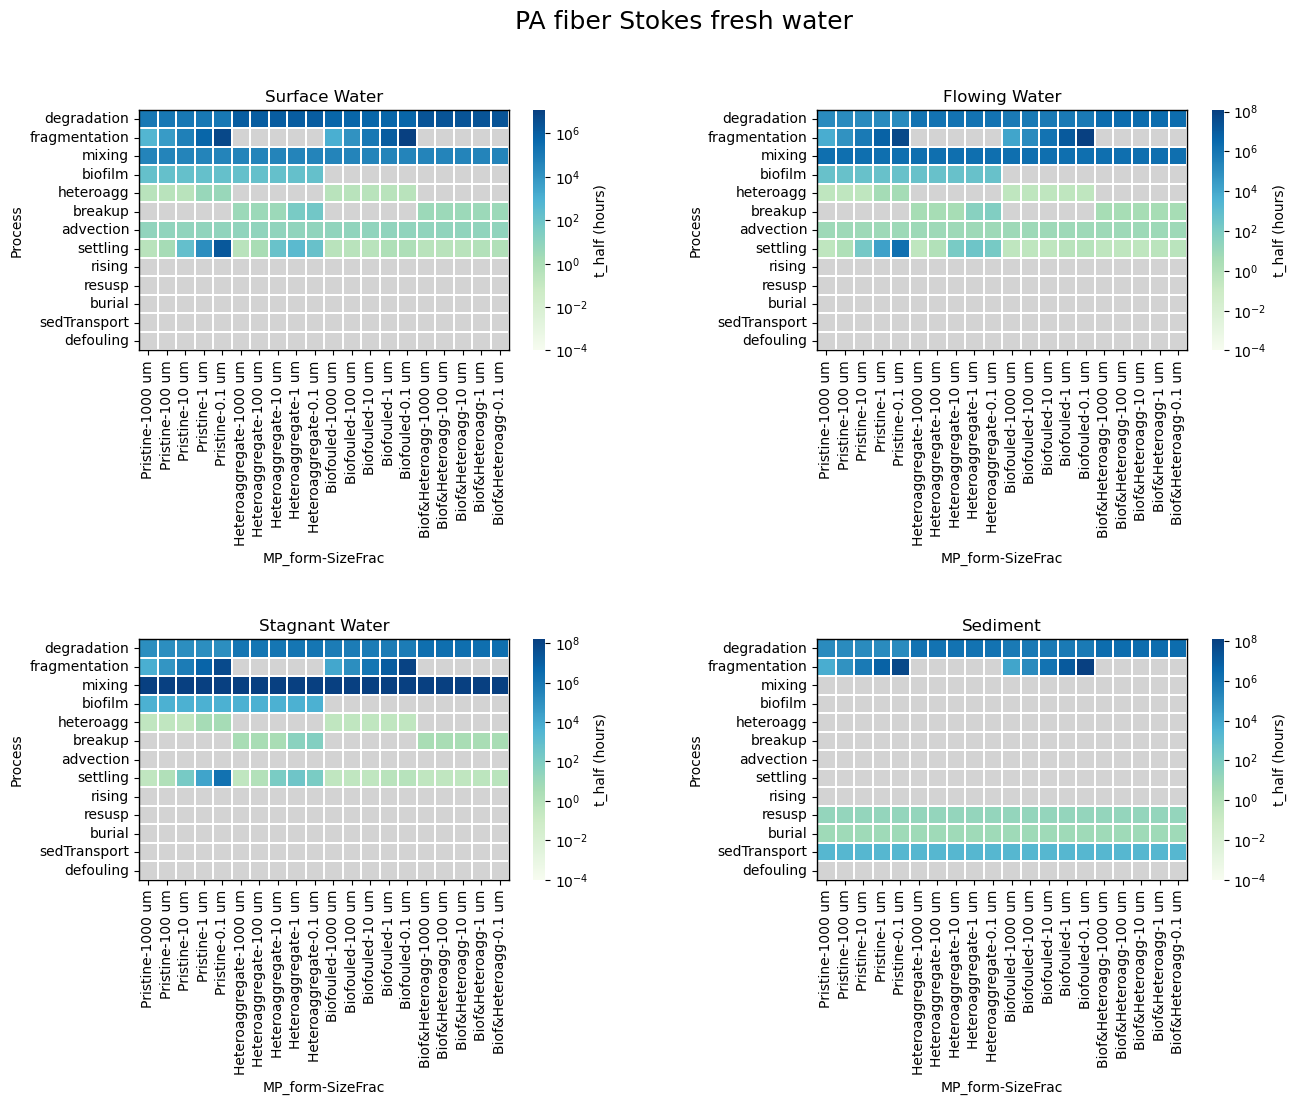

In [26]:
for i in range(len(Half_life_list)):    
    
    T_hm_array= [Half_life_list[i].loc["Surface Water"],Half_life_list[i].loc["Flowing Water"],Half_life_list[i].loc["Stagnant Water"],Half_life_list[i].loc["Sediment"]]
    T_hm_array_ts=[x.transpose() for x in T_hm_array]
    T_hm_array_ts=[y.replace(0, 0.0001) for y in T_hm_array_ts]
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplots_adjust(hspace=1.2, wspace=0.4)
    fig.suptitle(list_names[i], fontsize = 18)
    figname = "HeatMaps/{}.png".format(list_names[i])

    for y in range(len(T_hm_array_ts)):
        T_hm_array_ts[y].index = pd.CategoricalIndex(T_hm_array_ts[y].index, categories=["degradation", "fragmentation", "mixing", "biofilm", "heteroagg", "breakup", "advection", "settling", "rising", "resusp", "burial", "sedTransport", "defouling"])
        T_hm_array_ts[y].sort_index(level=0, inplace=True)
        log_norm = LogNorm(vmin=T_hm_array_ts[y].min().min(), vmax=T_hm_array_ts[y].max().max())
        
        # Use o subplot correspondente para plotar cada item
        ax = axs[y // 2, y % 2]
        sns.heatmap(T_hm_array_ts[y], mask=(T_hm_array_ts[y] == 0.0001), annot=False, annot_kws={"size": 12}, fmt=".2g", cmap='GnBu', linewidth=0.01, linecolor='white', square=True, robust=True, cbar_kws={'label': 't_half (hours)'}, norm=log_norm, ax=ax)
        ax.invert_xaxis()
        ax.set_title(compartments[y])
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(1)
        ax.set_facecolor('lightgrey')
    plt.show()
    fig.savefig(figname)

## Multyplots graphs: Concentration vs distance over time 

### - Organise results for dynamic plotting (GIF)

#### Function to extract concentration values by size fraction

In [28]:
def extract_SizeBins (t, comp, MPform,):
    Aa=[]
    Ab=[]
    Ac=[]
    Ad=[]
    Ae=[]
    for i in range(len(listRS)):
        Aa.append(ConcPlot.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"a")])
        Ab.append(ConcPlot.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"b")])
        Ac.append(ConcPlot.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"c")])
        Ad.append(ConcPlot.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"d")]) 
        Ae.append(ConcPlot.values[t, Clist.index("C_"+str(listRS[i])+comp+MPform+"e")]) 
    return [Aa, Ab, Ac, Ad, Ae]

#### Function to extract lists from a list by criteria

In [29]:
def listofindex(criteria,Clist):                                                                                                             
    lista= [[] for x in range(len(criteria))]
    for i in range(len(lista)):
        lista[i] = [n for n in Clist if criteria[i] in n[-3:]]
    return lista

#### Extract list of indexes needed for plotting

In [30]:
list_of_indexesMpType=listofindex(MPforms,Clist)
list_of_indexesCompartments=listofindex(riverComp,Clist)
list_ofindexesSizeBins=listofindex(sizeBin,Clist)

#### Define time resolution for extracting results (time_extract)

In [31]:
numTstep_hour=(60*60/stepSize)
Time_months=t_span[::(int(numTstep_hour*24*30))]
Time_days=t_span[::(int(numTstep_hour*24))]
Time_halfMonth=t_span[::(int(numTstep_hour*24*15))]
Time_5days=t_span[::(int(numTstep_hour*24*5))]#5 days

In [32]:
time_extract=Time_months

#### Extract data for plotting

#### Set x values (distance in km)

In [33]:
#Distance values
x =[d/1000 for d in RS_cumLength_m]
compartmentsLabel=["Surface\n Water", "Flowing\n Water", "Stagnant\n Water", "Sediment"]

#### Dataframe of y values (num/m$^3$)

In [34]:
y_multiplot_time= [[] for t in range(len(time_extract))]
for t in range(len(time_extract)):
    y_multiplot =pd.DataFrame(index=compartments, columns=MPformslabels)
    #Estimate relative abundance of MP types in the whole river and of particles per compartment
    for j in range(len(compartments)):
            for k in range(len(MPforms)):
                y_multiplot.iloc[j,k] = extract_SizeBins(int(time_extract[t]/stepSize), str(j+1),MPforms[k])  
    y_multiplot_time[t]=y_multiplot               
#y_multiplot_time     

NameError: name 'ConcPlot' is not defined

#### Distribution of MPs per aggregation state and compartment over time relative to particle number


In [ ]:
MpTypeNum_t=pd.DataFrame(index=range(len(time_extract)),columns=["Timepoint (min)"]+[m+" (Total number)" for m in MPformslabels]+["Total"])
RelativeAbun_MPtype_t=pd.DataFrame(0, columns=["Timepoint (days)"]+[m+" (%)" for m in MPformslabels], index=MpTypeNum_t.index)
compNum_t=pd.DataFrame(index=range(len(time_extract)),columns=["Timepoint (min)"]+[m+" (Total number)" for m in compartments]+["Total"])
RelativeAbun_Comp=pd.DataFrame(0, columns=["Timepoint (days)"]+[m+" (%)" for m in compartments], index=MpTypeNum_t.index)
for t in range(len(time_extract)):
    #Convert concentration to particle number
    PartNum_timestep=ConcFinal_num_m3.iloc[int(time_extract[t]/stepSize)]*dilution_vol_m3
    MpTypeNum_t.iloc[t,len(MPforms)+1]=sum(PartNum_timestep)
    PartNum_timestep=PartNum_timestep.to_frame()
    for mp in range(1,1+len(MPforms)):
        MpTypeNum_t.iloc[t,mp]=sum(PartNum_timestep.loc[list_of_indexesMpType[mp-1], :][time_extract[t]].to_list())
        if MpTypeNum_t.iloc[t,len(MPforms)+1] == 0:
            RelativeAbun_MPtype_t.iloc[t,mp]= 0
        else:
            RelativeAbun_MPtype_t.iloc[t,mp]=round((MpTypeNum_t.iloc[t,mp]/MpTypeNum_t.iloc[t,len(MPforms)+1])*100,2)
    for com in range(1,1+len(compartments)):
        compNum_t.iloc[t,com]=sum(PartNum_timestep.loc[list_of_indexesCompartments[com-1], :][time_extract[t]].to_list())
        if MpTypeNum_t.iloc[t,len(MPforms)+1]== 0:
            RelativeAbun_Comp.iloc[t,com]=0
        else:
            RelativeAbun_Comp.iloc[t,com]=round((compNum_t.iloc[t,com]/MpTypeNum_t.iloc[t,len(MPforms)+1])*100,2)
    RelativeAbun_MPtype_t.iloc[t,0]=t
    MpTypeNum_t.iloc[t,0]=time_extract[t]/stepSize
    compNum_t.iloc[t,0]=time_extract[t]/stepSize
    RelativeAbun_Comp.iloc[t,0]=t

#### - Relative abundance of MPs aggregation states in the whole system per time step

In [ ]:
compNum_t

In [ ]:
RelativeAbun_MPtype_t

#### - Fractionation of MPs per compartmet over time for the whole system

In [ ]:
RelativeAbun_Comp

#### - Relative abundance per size fraction after 1 year run

In [ ]:
#Define time step (1year)
time=range(len(t_span))
t=time[-1]# last time step 

In [ ]:
# Estimate total number of particles per size fraction in each compartment for the whole river
list_SizeFracNum_comp = []

for i in range(len(list_Nfinal_num)): 
    SizeFracNum_comp=pd.DataFrame(index=sizeBinLabel,columns= compartments)
    for siz in range(len(sizeBin)):
        for co in range(len(SizeFracNum_comp.columns)):  
            list_sb= [n for n in list_of_indexesCompartments[co] if sizeBin[siz] in n[-3:]]
            SizeFracNum_comp.iloc[siz,co]=sum(list_Nfinal_num[i][list_sb].iloc[t].to_list())
            list_SizeFracNum_comp.append(SizeFracNum_comp)

In [ ]:
Total_num_water=sum(sum(SizeFracNum_comp[compartments[0:3]].values))
Total_num_sediment=sum(SizeFracNum_comp[compartments[-1]].values)
RelativeAbun_SizeFrac=pd.DataFrame(index=sizeBinLabel,columns=["Relative abundance in water (%)", "Relative abundance in sediment (%)"])
for siz in range(len(sizeBin)):
    if sum(SizeFracNum_comp.iloc[siz][compartments[0:3]].values)==0:
        RelativeAbun_SizeFrac.iloc[siz,0]=0
    else:
        RelativeAbun_SizeFrac.iloc[siz,0]=round((sum(SizeFracNum_comp.iloc[siz][compartments[0:3]].values)/Total_num_water)*100,2)
    if SizeFracNum_comp.iloc[siz][compartments[-1]]==0:
        RelativeAbun_SizeFrac.iloc[siz,1]=0
    else:
        RelativeAbun_SizeFrac.iloc[siz,1]=round((SizeFracNum_comp.iloc[siz][compartments[-1]]/Total_num_sediment)*100,2)
RelativeAbun_SizeFrac

In [ ]:
# Estimate total number of particles per size fraction in each compartment for the downstream section (last 200 km )
list_SizeFracNum_comp_downs = []

for i in range(len(list_Nfinal_num)):
    SizeFracNum_comp_downs=pd.DataFrame(index=sizeBinLabel,columns= compartments)
    for siz in range(len(sizeBin)):
        for co in range(len(SizeFracNum_comp.columns)):
            list_sb= [n for n in list_of_indexesCompartments[co] if sizeBin[siz] in n[-3:]]
            list_sb_downstream=list_sb[20*4-4*4:]
            SizeFracNum_comp_downs.iloc[siz,co]=sum(list_Nfinal_num[i][list_sb_downstream].iloc[t].to_list())
        list_SizeFracNum_comp_downs.append(SizeFracNum_comp_downs)

SizeFracNum_comp_downs
Total_num_water_downs=sum(sum(SizeFracNum_comp_downs[compartments[0:3]].values))
Total_num_sediment_downs=sum(SizeFracNum_comp_downs[compartments[-1]].values)

list_RelativeAbun_SizeFrac_downs = []

for i in range(len(list_SizeFracNum_comp_downs)):
    RelativeAbun_SizeFrac_downs=pd.DataFrame(index=sizeBinLabel,columns=["Relative abundance in water (%)", "Relative abundance in sediment (%)"])
    for siz in range(len(sizeBin)):
        if sum(list_SizeFracNum_comp_downs[i].iloc[siz][compartments[0:3]].values)==0:
            RelativeAbun_SizeFrac_downs.iloc[siz,0]=0
        else:
            RelativeAbun_SizeFrac_downs.iloc[siz,0]=round((sum(list_SizeFracNum_comp_downs[i].iloc[siz][compartments[0:3]].values)/Total_num_water_downs)*100,2)
        if SizeFracNum_comp_downs.iloc[siz][compartments[-1]]==0:
            RelativeAbun_SizeFrac_downs.iloc[siz,1]=0
        else:
            RelativeAbun_SizeFrac_downs.iloc[siz,1]=round((list_SizeFracNum_comp_downs[i].iloc[siz][compartments[-1]]/Total_num_sediment_downs)*100,2)
        list_RelativeAbun_SizeFrac_downs.append(RelativeAbun_SizeFrac_downs)

### PLOT

#### Choose style and colour palette

In [ ]:
palette = plt.get_cmap('Set2')
plt.style.use('seaborn-white')
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='ivory', alpha=0.5)
props2 = dict(boxstyle='round', facecolor='white', alpha=0.5)

### Dynamic plot

In [ ]:
#Move to figures folder
#os.chdir(results_figures_path)
#Generate animation
#fig, axs = plt.subplots(len(compartments),len(MPforms), figsize=(30, 15),sharex='col')
#labels = ['0.1 um', '1 um', '10 um', '100 um', '1000 um']
#if imputPulse != 0:
#    if imputFlow==0:
#        fig.suptitle( composition +" microplastics fate in generic river over time (pulse= "+ str(imputPulse)+" particles of 1mm)"+f" ({list_names[0]})", fontsize=30)
#    else:
#        fig.suptitle( composition +" microplastics fate in generic river over time (pulse= "+ str(imputPulse)+" + inflow= "+str(imputFlow)+" particles/min of 1mm )"+f" ({list_names[0]})", fontsize=30)
#else:
#    fig.suptitle( composition +" microplastics fate in generic river over time (inflow= "+str(imputFlow)+" particles/min of 1mm)"+f" ({list_names[0]})", fontsize=30)
#camera = Camera(fig)
#for t in range(len(time_extract)): 
#    for j in range(len(compartments)):
#        for k in range(len(MPforms)):
            #Plot
#            y = y_multiplot_time[t].iloc[j,k]
#            axs[j,k].plot(x, y[0], linewidth=2.5,color=palette(0), label='0.1 um')
#            axs[j,k].plot(x, y[1], linewidth=2.5,color=palette(1), label='1 um')
#            axs[j,k].plot(x, y[2], linewidth=2.5,color=palette(2), label='10 um')
#            axs[j,k].plot(x, y[3], linewidth=2.5,color=palette(3), label='100 um')
#            axs[j,k].plot(x, y[4], linewidth=2.5,color=palette(4), label='1000 um')
#            axs[j,k].text(0.90,0.90,str(int(time_extract[t]/60/60/24)) + ' days', bbox=props, fontsize=12, transform=axs[j,k].transAxes, ha='center', va='center')
#            #Set axes labels and title
#            if j== 0:
#                axs[j,k].text(0.5,1.1, MPformslabels[k]+ "\n " +str(RelativeAbun_MPtype_t.iloc[t,k+1])+ " %",fontsize=20, bbox=props2, transform= axs[j,k].transAxes, ha='center')        
#            else:
#                axs[j,k].set_title(MPformslabels[k]+ " " + composition+ " particles in "+ compartments[j],fontsize=15)
#      
#            if k==0:
#                axs[j,k].text(-0.25, 0.5, compartmentsLabel[j]+"\n"+str(RelativeAbun_Comp.iloc[t,j+1])+" %",fontsize=20,rotation=0, va='center',ha='center',bbox=props2, transform=axs[j,k].transAxes)
                
        
#            axs[j,k].set_yscale('log')
#            if j==0:
#                axs[j,k].set_ylim(10**-9,10**1)
#            elif j==1:
#                axs[j,k].set_ylim(10**-9,10**1)
#            elif j== 2:
#                axs[j,k].set_ylim(10**-9,10**1)
#            else:
#                axs[j,k].set_ylim(10**-9,10**1)
#            axs[j,k].set_xlim(x[0],x[-1])
#            axs[j,k].tick_params(axis='x', labelsize=12)
#            axs[j,k].tick_params(axis='y', labelsize=12)
           
    # Axis titles
#    plt.text(0.05, 0.5, "Concentration of particles " +ConcPlot_units[0], fontsize=20, transform=plt.gcf().transFigure, rotation='vertical',ha='center', va='center')
#    plt.text(0.5, 0.08, "Distance (km)", fontsize=20, transform=plt.gcf().transFigure, ha='center', va='center')
    #plt.legend(labels,bbox_to_anchor=(0.5, -0.18), loc='center',ncol=5, fontsize=15 )
#    camera.snap()
           
#if imputPulse != 0:
#    animationTitle= composition+ConcPlot_units[1]+f"_Pulse_({list_names[0]})".gif"
#else:
#    animationTitle= composition+ConcPlot_units[1]+"_ConstantInflow_"+str(imputFlow)+f"({list_names[0]}).gif"

#animation = camera.animate()
#animation.save(animationTitle, writer='matplotlib.animation.PillowWriter', fps=2) 
#os.chdir(cwd)

## Plot after 360 days

#### Static plot (t=tfinal)

In [ ]:
t=len(time_extract)-1

In [ ]:
import matplotlib.ticker as ticker
from matplotlib import ticker


fig2, axs = plt.subplots(len(compartments),len(MPforms), figsize=(15, 10),sharex='col', sharey= "row", squeeze="True")

labels = ['0.1 um', '1 um', '10 um', '100 um', '1000 um']
if imputFlow == 0:
    fig2.suptitle( composition +" plastic particles after "+str(int(time_extract[t]/60/60/24)) + " days (pulse= "+ str(imputPulse)+" particles of 1mm)" , fontsize=18,  y=0.95)
    
else:
    fig2.suptitle( composition +" plastic particles after "+str(int(time_extract[t]/60/60/24)) + f" days ({list_names[0]})" , fontsize=18,  y=0.95)

for j in range(len(compartments)):
    if j == 3:
        for k in range(len(MPforms)):
            #Plot
            y = extract_SizeBins (t, riverComp[j], MPforms[k])
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[0]], linewidth=2.5,color=palette(0), label='0.1 um')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[1]], linewidth=2.5,color=palette(1), label='1 um')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[2]], linewidth=2.5,color=palette(2), label='10 um')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[3]], linewidth=2.5,color=palette(3), label='100 um')
            axs[j,k].plot(x, [e * 10**6/1.3 for e in y[4]], linewidth=2.5,color=palette(4), label='1000 um')

            if k==3:
                axs[j,k].text(1.2, 0.5, compartmentsLabel[j] ,fontsize=15,rotation=0, va='center',ha='center', transform=axs[j,k].transAxes)

            axs[j,k].set_yscale('log')
            axs[j,k].set_ylim(10**-9,1000000)
            if k == 0:
                axs[j,k].set_ylabel("Conc (mg/g)", fontsize=15)
            axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            axs[j,k].set_xlim(x[0],x[-1])
            axs[j,k].tick_params(axis='x', labelsize=12, direction='inout', length=6, width=1, grid_alpha=0.5)
            axs[j,k].tick_params(axis='y',labelsize=10, direction='inout', length=6, width=1, grid_alpha=0.5) 
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_scientific(True) 
            formatter.set_powerlimits((-1,1)) 
    else:
        for k in range(len(MPforms)):
            #Plot
            y = extract_SizeBins (t, riverComp[j], MPforms[k])
            axs[j,k].plot(x, y[0], linewidth=2.5,color=palette(0), label='0.1 um')
            axs[j,k].plot(x, y[1], linewidth=2.5,color=palette(1), label='1 um')
            axs[j,k].plot(x, y[2], linewidth=2.5,color=palette(2), label='10 um')
            axs[j,k].plot(x, y[3], linewidth=2.5,color=palette(3), label='100 um')
            axs[j,k].plot(x, y[4], linewidth=2.5,color=palette(4), label='1000 um')
            if j== 0:
                axs[j,k].text(0.5,1.1, MPformslabels[k] ,fontsize=15, transform= axs[j,k].transAxes, ha='center')        
            if k==3:
                axs[j,k].text(1.2, 0.5, compartmentsLabel[j] ,fontsize=15,rotation=0, va='center',ha='center', transform=axs[j,k].transAxes)
            if k == 0:
                axs[j,k].set_ylabel("Conc "+ ConcPlot_units[0], fontsize=15)
            axs[j,k].set_yscale('log')
            
            if j==0:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            elif j==1:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            elif j== 2:
                axs[j,k].set_ylim(10**-9,10**1)
                axs[j,k].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
            axs[j,k].set_xlim(x[0],x[-1])

            axs[j,k].tick_params(axis='x', labelsize=10, direction='inout', length=6, width=1, grid_alpha=0.5)
            axs[j,k].tick_params(axis='y',labelsize=10, direction='inout', length=6, width=1, grid_alpha=0.5)
            from matplotlib import ticker
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_scientific(True) 
            formatter.set_powerlimits((-1,1)) 
            axs[j,k].minorticks_on()
            
           
# Axis titles
#plt.text(0.02, 0.5, "Concentration of particles (Num/$m^3$)", fontsize=15, transform=plt.gcf().transFigure, rotation='vertical',ha='center', va='center')
plt.text(0.5, 0.08, "Distance (km)", fontsize=15, transform=plt.gcf().transFigure, ha='center', va='center')
#plt.legend(labels,bbox_to_anchor=(0.5, -0.18), loc='center',ncol=5, fontsize=15 )
plt.subplots_adjust(wspace=0.02,hspace=0.1)
handles, labels = axs[j,k].get_legend_handles_labels()
fig2.legend(handles, labels, bbox_to_anchor=(0.5, 0.04), loc='center',ncol=5, fontsize=15)
if imputPulse != 0:
    fig2_label= "ConcvsDist_Multiplot_"+ composition +"_"+ConcPlot_units[1]+"_Pulse.png"
else:
    fig2_label= "ConcvsDist_Multiplot_"+ composition +"_"+ConcPlot_units[1]+"_ConstantInflow.png"
figname = f"{composition} plastic particles in 360 days ({list_names[0]}).png"
fig2.savefig(figname)